In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor

from dask import dataframe as dd

In [11]:
dtypes = {
        'assists'           : 'uint8',
        'boosts'            : 'uint8',
        'damageDealt'       : 'float32',
        'DBNOs'             : 'uint8',
        'headshotKills'     : 'uint8', 
        'heals'             : 'uint8',    
        'killPlace'         : 'uint8',    
        'killPoints'        : 'uint16',    
        'kills'             : 'uint8',    
        'killStreaks'       : 'uint8',    
        'longestKill'       : 'float32',
        'matchDuration'     : 'uint8',
        'maxPlace'          : 'uint8',    
        'numGroups'         : 'uint8',    
        'rankPoints'        : 'uint8',
        'revives'           : 'uint8',    
        'rideDistance'      : 'float32',    
        'roadKills'         : 'uint8',    
        'swimDistance'      : 'float32',    
        'teamKills'         : 'uint8',    
        'vehicleDestroys'   : 'uint8',    
        'walkDistance'      : 'float32',    
        'weaponsAcquired'   : 'uint8',    
        'winPoints'         : 'uint8', 
        'winPlacePerc'      : 'float32' 
}

In [12]:
# dfd = dd.read_csv(
#     '../Data/raw_data/train_V2.csv', 
#     delimiter=',',
#     blocksize=32000000 # = 32 Mb chunks = 32 * 10^6 bytes
# )
dfd = train = pd.read_csv("../Data/raw_data/train_V2.csv", dtype=dtypes)
# test = pd.read_csv("../Data/raw_data/test_V2.csv", dtype=dtypes)

In [13]:
dfd_num_cols = train.dtypes[train.dtypes != 'object'].index.tolist()
dfd_num_cols.remove('winPlacePerc')
dfd_cate_cols = train.dtypes[train.dtypes == 'object'].index.tolist()

In [14]:
mem_size = train.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(mem_size))

Memory usage of dataframe is 322.31 MB


In [15]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [16]:
# dfd = reduce_mem_usage(train)

**NOTE** using the function resulted in an increase of memory usage. for that reason, we are not using this.

In [ ]:
dfd 

# 1- Data Cleaning

### 1.1 Null Values

since the number of rows with missing values is only 1, we can remove that row since its represents very insignificant portion of the information lost from the data, as the data is over 4 million records.

In [18]:
dfd.isnull().sum() 

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [19]:
# retrieving row with null value
dfd_mv_rows = dfd[dfd['winPlacePerc'].isna()]
dfd_mv_rows 

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [20]:
missing_row = dfd_mv_rows 
missing_row_index = missing_row.index[0]
missing_row_index

2744604

In [21]:
dfd_cle_pt1 = dfd.drop([missing_row_index])

In [22]:
dfd_cle_pt1 = dfd_cle_pt1.reset_index(drop=True)

### 1.2 Data Skewness

Two scores used for skewness:
- High **kurtosis** in a data set is an indicator that data has heavy tails or outliers
    - if the number is greater than +1, the distribution is too peaked
- high **skew** score (negative or postive) indicates asymmetry of distribution
    - A skewness value greater than 1 or less than -1 indicates a highly skewed distribution

In [23]:
skew_df = pd.DataFrame(index=dfd_num_cols)

# Caculate Skewness 
skew_df['Skew'] = skew(dfd_cle_pt1[dfd_num_cols], axis=0, bias=True) 
# Calculate the kurtosis
skew_df['Kurtosis'] = kurtosis(dfd_cle_pt1[dfd_num_cols], axis=0, bias=True) 

,Skew,Kurtosis
assists,3.634817,21.230686
boosts,1.953601,4.299426
damageDealt,2.921027,20.112858
DBNOs,3.235734,22.830935
headshotKills,5.271679,106.213486
heals,3.491547,18.699249
kills,3.421993,27.438755
killStreaks,1.293276,2.115788
longestKill,3.989906,24.295204
rankPoints,-1.591426,1.570372


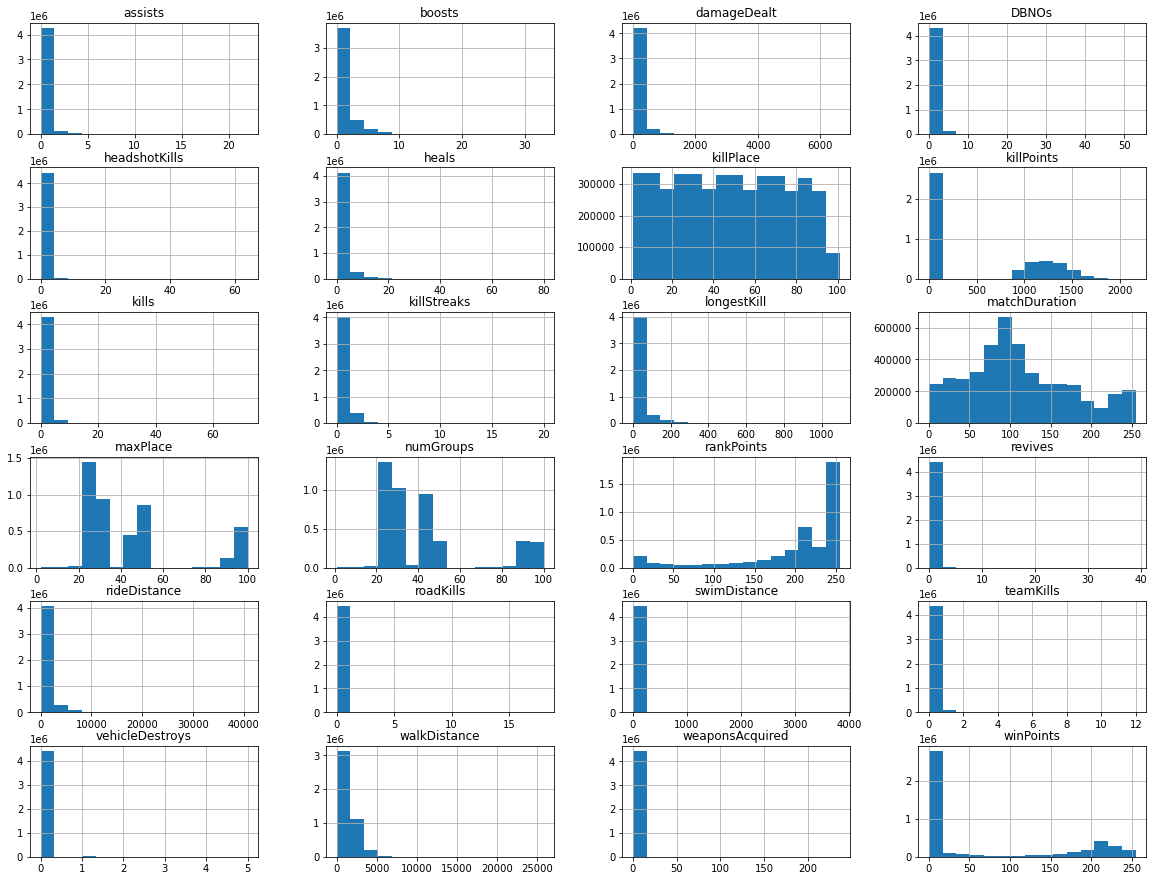

In [24]:
display(skew_df[ (np.absolute(skew_df['Skew'])>1) & (skew_df['Kurtosis']>1) ])

dfd_cle_pt1[dfd_num_cols].hist(bins=15, figsize=(20, 18), layout=(7, 4))
plt.title('Data Distributinos')
plt.show()

**INSIGHTS**
- very high Kurtosis scores for assists, damageDealt, DBNOs, headshotKills, heals, kills, longestKill, revives, roadKills, swimDistance, teamKills, vehicleDestroys, weaponsAcquired.
    - indicates outliers present within those features
- we will then apply data transformation method or normalization to the data to reduce skewness

### 1.2.1 Remove outliers

In [26]:
dfd_cle_pt1

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,0,0.0000,0,0.000,0,0,244.800003,1,186,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,...,0,0.0045,0,11.040,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,0,0.0000,0,0.000,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,...,0,0.0000,0,0.000,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,0,0.0000,0,0.000,0,0,49.750000,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446960,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.000000,0,0,0,74,...,0,1292.0000,0,0.000,0,0,1019.000000,3,227,0.1786
4446961,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150002,0,0,0,69,...,0,0.0000,0,0.000,0,0,81.699997,6,0,0.2935
4446962,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.060001,0,0,0,66,...,0,0.0000,0,2.184,0,0,788.700012,4,0,0.4815
4446963,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.399994,1,1,2,11,...,2,0.0000,0,0.000,0,0,2748.000000,8,0,0.8000


In [131]:
Q1 = np.percentile(dfd_cle_pt1['assists'], 25,
                   interpolation = 'midpoint')
Q3 = np.percentile(dfd_cle_pt1['assists'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Upper bound
upper = np.where(dfd_cle_pt1['assists'] >= (Q3+1.5*IQR))
dfd_cle_pt2 = dfd_cle_pt1.drop(upper[0])

# Lower bound
lower = np.where(dfd_cle_pt2['assists'] <= (Q1-1.5*IQR))
dfd_cle_pt2 = dfd_cle_pt2.drop(lower[0], axis=0)

print("Old Shape: ", dfd_cle_pt1.shape)
print("New Shape: ", dfd_cle_pt2.shape)

Old Shape:  (4446965, 29)
New Shape:  (0, 29)


C:\Users\modaj\AppData\Local\Temp\ipykernel_162684\2756430060.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(dfd_cle_pt1['assists'], 25,
C:\Users\modaj\AppData\Local\Temp\ipykernel_162684\2756430060.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(dfd_cle_pt1['assists'], 75,


#### 1.2.1.1 IQR method

**NOTE** this method removes most of the data points if not all of them, so we consider this approach inappropriate for our data.

#### 1.2.1.2 winsorization method

In [141]:
min_thresh = []
max_thresh = []

def Winsorization_outliers(df):
    q1 = np.percentile(df , 1)
    q3 = np.percentile(df , 99)
    for i in df:
        if i > q3:
            max_thresh.append(i)
        if i < q1:
            min_thresh.append(i)
    
    if len(max_thresh) > 0:
        print(f'Outlier value threshold upper bound for ({df.name}): {min(max_thresh)}')
    if len(min_thresh) > 0:
        print(f'Outlier value threshold lower bound for ({df.name}): {max(min_thresh)}')
    print('-----')

thresholds = {}
# #     print("Outliers:", len(out), 'value')
# cols = dfd_cle_wins[dfd_num_cols].columns.tolist()
# cols.remove('rankPoints')
cols = ['assists', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'kills', 'longestKill', 'revives', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'weaponsAcquired']

# GENERAL CASE: log transformation
for col in cols:    
    thresholds[col] = Winsorization_outliers(dfd_cle_pt1[col])

Outlier value threshold upper bound for (assists): 4
-----
Outlier value threshold upper bound for (damageDealt): 4
-----
Outlier value threshold upper bound for (DBNOs): 4
-----
Outlier value threshold upper bound for (headshotKills): 4
-----
Outlier value threshold upper bound for (heals): 4
-----
Outlier value threshold upper bound for (kills): 4
-----
Outlier value threshold upper bound for (longestKill): 4
-----
Outlier value threshold upper bound for (revives): 3
-----
Outlier value threshold upper bound for (roadKills): 1
-----
Outlier value threshold upper bound for (swimDistance): 1
-----
Outlier value threshold upper bound for (teamKills): 1
-----
Outlier value threshold upper bound for (vehicleDestroys): 1
-----
Outlier value threshold upper bound for (weaponsAcquired): 1
-----


**NOTE** some upper bound values (like damageDealt: 4) are still too low an upper threshold to remove values from. we don't consider this approach as 99th percentile still means potentially that more than 100000 rows may be removed, which results in signficant amound of data loss

#### 1.2.1.3 Isolation forest method (clustering)

In [136]:
from sklearn.ensemble import IsolationForest

dfd_cle_if = dfd_cle_pt1.copy()

def Iso_outliers(df):
    iso = IsolationForest(random_state = 1, contamination= 'auto')
    preds = iso.fit_predict(df.values.reshape(-1,1))
    data = pd.DataFrame()
    data['cluster'] = preds
    print(data['cluster'].value_counts().sort_values(ascending=False))

cols = ['assists', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'kills', 'longestKill', 'revives', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'weaponsAcquired']
for col in cols:
    Iso_outliers(dfd_cle_if[col])
    break

 1    3667659
-1     779306
Name: cluster, dtype: int64


**NOTE** too many to be removed for the sake of outliers! we don't consider this approach for now. 

**NOTE** since all of the automated approaches that were tried didn't provide great results, we will remove outliers based on visualization for each feature and filtering out the extreme values through analysis.

#### 1.2.1.4 visualization method

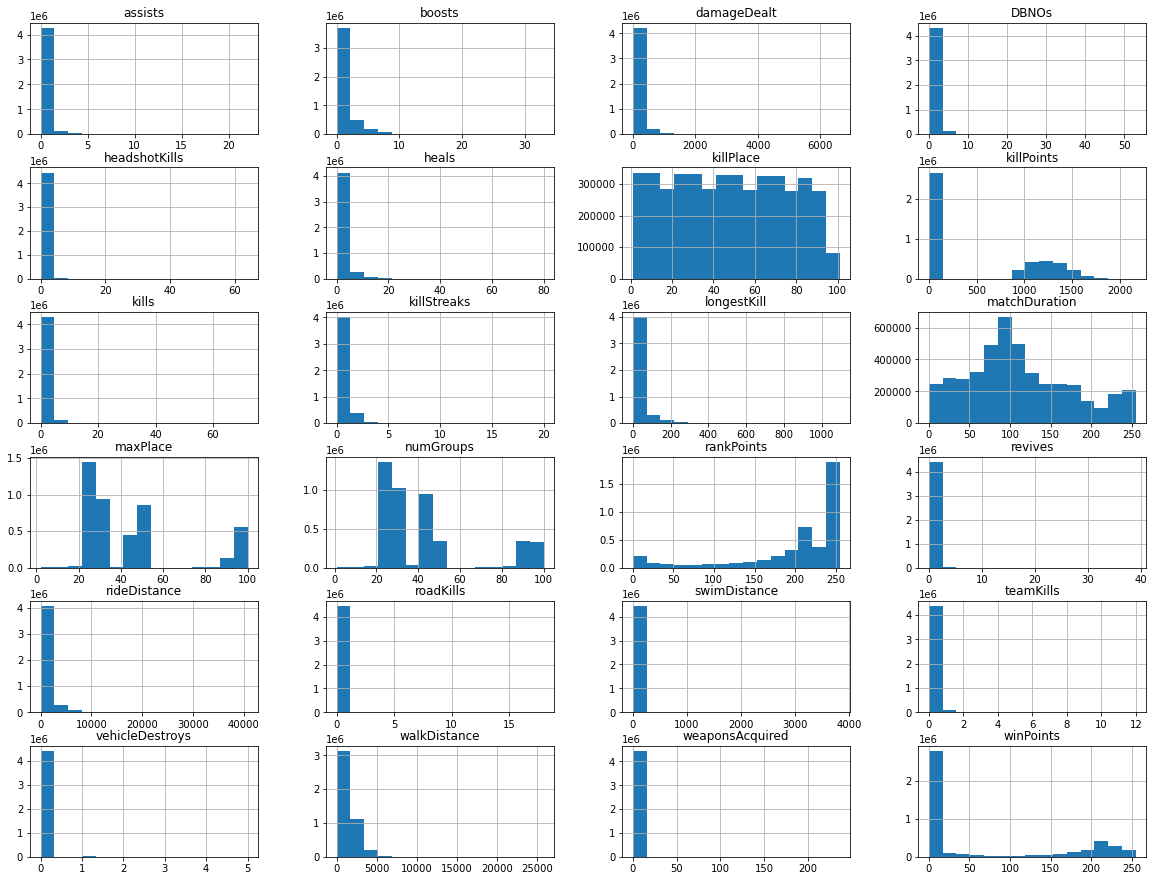

In [27]:
dfd_cle_pt1[dfd_num_cols].hist(bins=15, figsize=(20, 18), layout=(7, 4))
plt.title('Data Distributinos')
plt.show()

**INSIGHTS**
- assists: filter above 8
- damageDealt: filter above 2000
- DBNOs: filter above 14
- headshotKills: filter above 10
- heals: filter above 18
- kills: filter above 17
- killStreaks: filter above 5
- longestKill: filter above 420
- revives: filter above 5
- roadKills: filter above 3
- swimDistance: filter above 500
- teamKills: filter above 3
- vehicleDestroys: filter above 2
- walkDistance: filter above 5000
- weaponsAcquired: filter above 20

In [28]:
dfd_cle_viz = dfd_cle_pt1.copy()
display(dfd_cle_viz.shape)

dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['assists']>8)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['boosts']>13)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['damageDealt']>2000)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['DBNOs']>14)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['headshotKills']>10)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['heals']>18)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['kills']>10)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['killStreaks']>5)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['longestKill']>420)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['revives']>5)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['rideDistance']>11000)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['roadKills']>3)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['swimDistance']>500)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['teamKills']>3)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['vehicleDestroys']>1)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['walkDistance']>5000)]
dfd_cle_viz = dfd_cle_viz[~(dfd_cle_viz['weaponsAcquired']>20)]
dfd_cle_viz = dfd_cle_viz.reset_index(drop=True)
display(dfd_cle_viz.shape)
print(f'{dfd_cle_pt1.shape[0] - dfd_cle_viz.shape[0]} Rows Have Been Removed')

(4446965, 29)

(4398809, 29)

48156 Rows Have Been Removed


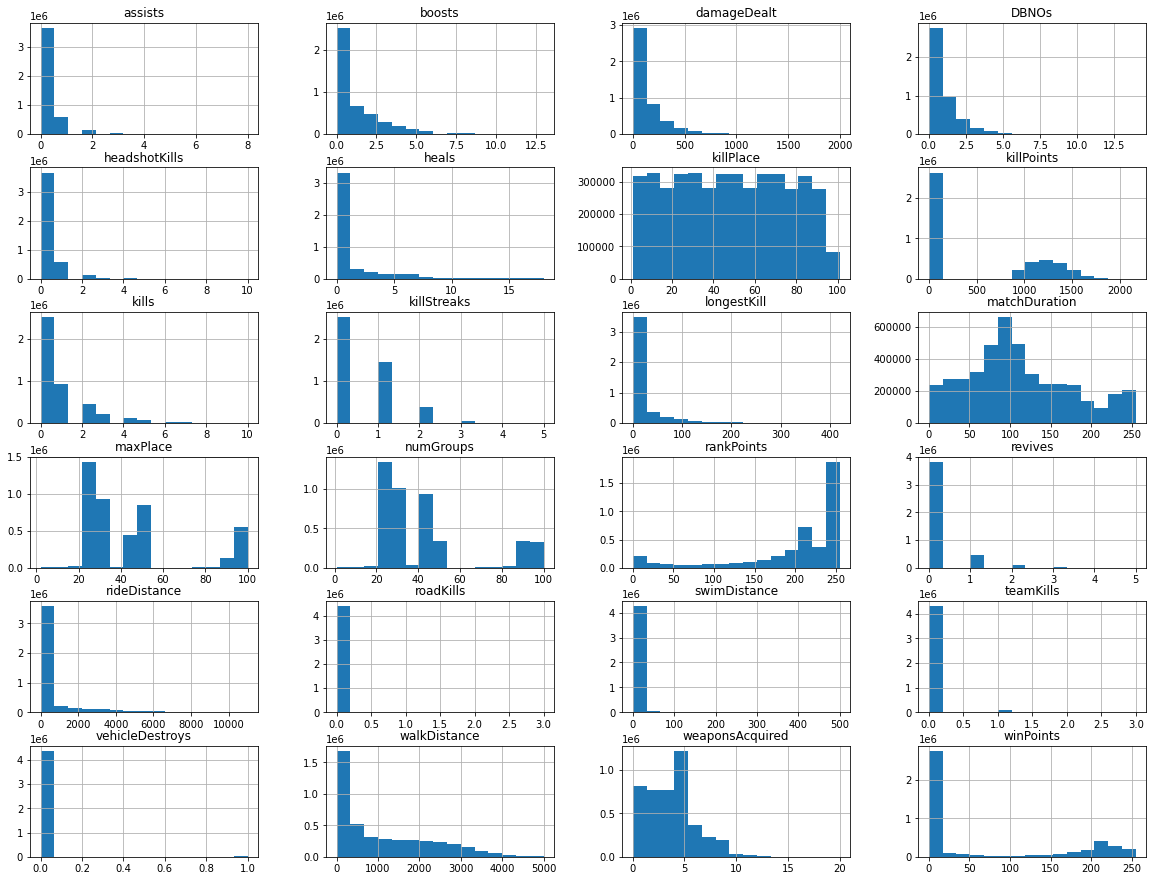

In [29]:
dfd_cle_viz[dfd_num_cols].hist(bins=15, figsize=(20, 18), layout=(7, 4))
plt.title('Data Distributions')
plt.show()

We successfully managed to decrease the skewness significantly by removing outliers, but it is still relatively skewed, so we now try normalization and data tranformation methods

### 1.2.2 Data Transformation /  Normalization

In [30]:
skew_df = pd.DataFrame(index=dfd_num_cols)

# Caculate Skewness 
skew_df['Skew'] = skew(dfd_cle_viz[dfd_num_cols], axis=0, bias=True) 
# Calculate the kurtosis
skew_df['Kurtosis'] = kurtosis(dfd_cle_viz[dfd_num_cols], axis=0, bias=True)
display(skew_df[ (np.absolute(skew_df['Skew'])>1) & (skew_df['Kurtosis']>1) ])

,Skew,Kurtosis
assists,3.303775,14.086081
boosts,1.921068,4.072970
damageDealt,2.189674,6.606508
DBNOs,2.483232,8.637667
headshotKills,3.449596,16.061007
heals,2.808696,9.172215
kills,2.382181,6.763885
killStreaks,1.230392,1.091321
longestKill,3.395375,13.551289
rankPoints,-1.593550,1.577988


In [31]:
# setting up data skewness dictionary for storing skew and kurtosis scores for different transformation methods applied 
data_skew_dict = {}
data_skew_dict['Skew'] = {}
data_skew_dict['Kurtosis'] = {}

#### 1.2.2.1 min-max method

In [229]:
from sklearn import preprocessing

dfd_cle_viz_norm = pd.DataFrame(preprocessing.normalize(dfd_cle_viz[dfd_num_cols]), columns=dfd_num_cols)
display(dfd_cle_viz_norm)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045945,0.950305,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.187457,0.000766,0.142431,0.000340
1,0.000000,0.000000,0.062107,0.000000,0.000000,0.000000,0.038702,0.000000,0.000000,0.000000,...,0.000000,0.000003,0.0,0.007496,0.0,0.0,0.973661,0.003395,0.000000,0.000435
2,0.003457,0.000000,0.235054,0.000000,0.000000,0.000000,0.162464,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.559290,0.006913,0.000000,0.002681
3,0.000000,0.000000,0.109433,0.000000,0.000000,0.000000,0.249467,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.674227,0.009979,0.000000,0.000554
4,0.000000,0.000000,0.416385,0.000000,0.000000,0.000000,0.187373,0.000000,0.004164,0.004164,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.207152,0.008328,0.000000,0.000781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037487,0.521276,0.000000,0.000000,...,0.000000,0.654507,0.0,0.000000,0.0,0.0,0.516210,0.001520,0.114995,0.000090
4398805,0.000000,0.003107,0.137177,0.000000,0.000000,0.000000,0.214387,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.253846,0.018642,0.000000,0.000912
4398806,0.000000,0.000000,0.071539,0.000000,0.000000,0.000000,0.079945,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.002645,0.0,0.0,0.955343,0.004845,0.000000,0.000583
4398807,0.000000,0.001449,0.065339,0.000362,0.000362,0.000724,0.003984,0.000000,0.000724,0.000362,...,0.000724,0.000000,0.0,0.000000,0.0,0.0,0.995302,0.002898,0.000000,0.000290


In [230]:
skew_df = pd.DataFrame(index=dfd_num_cols)

# Caculate Skewness 
skew_df['Skew'] = skew(dfd_cle_viz_norm[dfd_num_cols], axis=0, bias=True) 
# Calculate the kurtosis
skew_df['Kurtosis'] = kurtosis(dfd_cle_viz_norm[dfd_num_cols], axis=0, bias=True)

data_skew_dict['Skew']['min-max'] = skew_df['Skew'].apply(abs).mean()
data_skew_dict['Kurtosis']['min-max'] = skew_df['Kurtosis'].mean()

print('Skew Average: {:.2f} / Kurtosis Average: {:.2f}'.format(data_skew_dict['Skew']['min-max'], \
                                                       data_skew_dict['Kurtosis']['min-max']))
display(skew_df[ (np.absolute(skew_df['Skew'])>1) & (skew_df['Kurtosis']>1) ])

Skew Average: 8.37 / Kurtosis Average: 444.66


,Skew,Kurtosis
assists,6.643935,63.382271
boosts,3.247824,23.758377
damageDealt,2.262810,5.931463
DBNOs,3.540899,16.338602
headshotKills,5.778955,43.903828
heals,6.349417,67.259781
killPlace,2.109483,4.454398
kills,3.131719,12.534370
killStreaks,3.531720,15.976423
longestKill,4.793886,40.040184


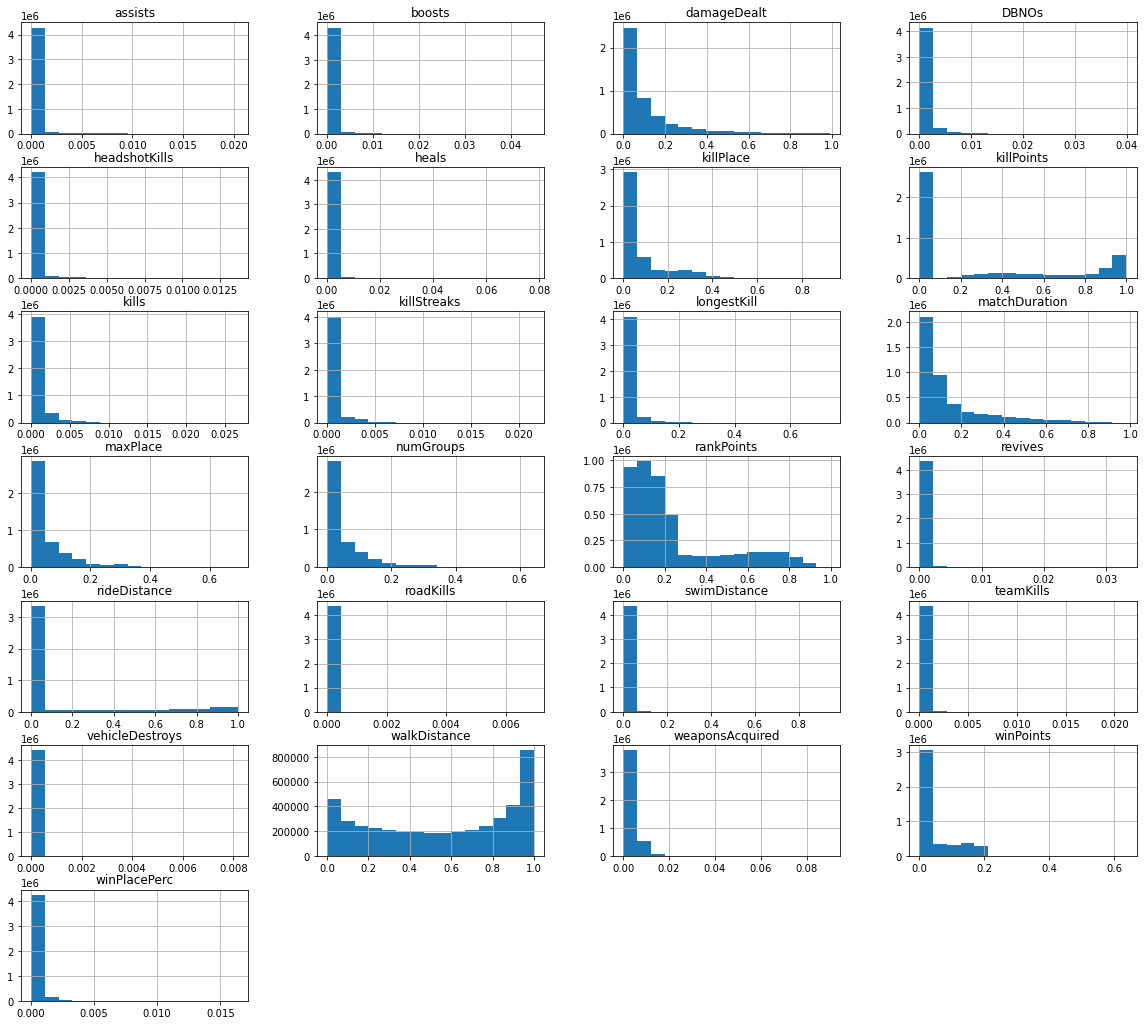

In [231]:
dfd_cle_viz_norm[dfd_num_cols].hist(bins=15, figsize=(20, 18), layout=(7, 4))
plt.title('Data Distributions')
plt.show()

#### 1.2.2.2 Log Transformation

In [232]:
# we can transform every feature except for rankPoints, since that has negative, which log of return NaN
dfd_cle_viz_log = dfd_cle_viz.copy()

cols = dfd_cle_viz_log[dfd_num_cols].columns.tolist()
cols.remove('rankPoints')

# # GENERAL CASE: log transformation
for col in cols:
    dfd_cle_viz_log[col] = np.log1p(dfd_cle_viz_log[col])

In [233]:
skew_df = pd.DataFrame(index=dfd_num_cols)

# Caculate Skewness 
skew_df['Skew'] = skew(dfd_cle_viz_log[dfd_num_cols], axis=0, bias=True) 
# Calculate the kurtosis
skew_df['Kurtosis'] = kurtosis(dfd_cle_viz_log[dfd_num_cols], axis=0, bias=True)

data_skew_dict['Skew']['log'] = skew_df['Skew'].apply(abs).mean()
data_skew_dict['Kurtosis']['log'] = skew_df['Kurtosis'].mean()

print('Skew Average: {:.2f} / Kurtosis Average: {:.2f}'.format(data_skew_dict['Skew']['log'], \
                                                       data_skew_dict['Kurtosis']['log']))


display(skew_df[ (np.absolute(skew_df['Skew'])>1) & (skew_df['Kurtosis']>1) ])

Skew Average: 2.67 / Kurtosis Average: 26.71


,Skew,Kurtosis
assists,2.218733,3.863957
headshotKills,2.295258,4.244052
killPlace,-1.283547,1.251726
matchDuration,-1.730259,4.336610
rankPoints,-1.593550,1.577988
revives,2.589905,5.657897
roadKills,20.444971,447.697021
swimDistance,4.301515,17.664360
teamKills,6.989962,49.815598
vehicleDestroys,11.786200,136.973053


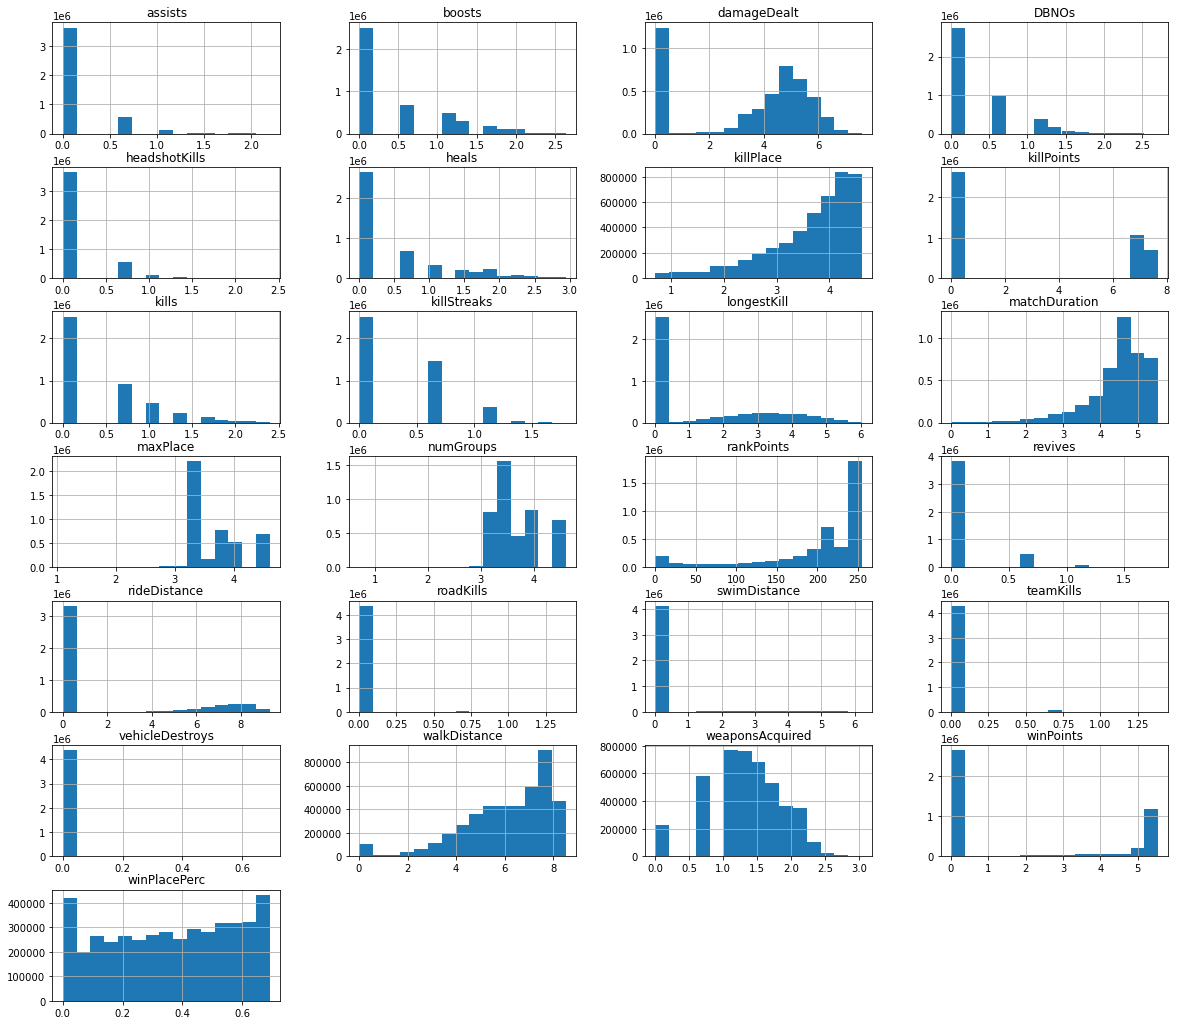

In [234]:
dfd_cle_viz_log[dfd_num_cols].hist(bins=15, figsize=(20, 18), layout=(7, 4))
plt.title('Data Distributinos')
plt.show()

#### 1.2.2.3 Power Transformation

In [32]:
from sklearn.preprocessing import PowerTransformer
dfd_cle_viz_pow = dfd_cle_viz.copy()

pw = PowerTransformer()
dfd_cle_viz_pow[dfd_num_cols] = pw.fit_transform(dfd_cle_viz_pow[dfd_num_cols])

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [33]:
skew_df = pd.DataFrame(index=dfd_num_cols)

# Caculate Skewness 
skew_df['Skew'] = skew(dfd_cle_viz_pow[dfd_num_cols], axis=0, bias=True) 
# Calculate the kurtosis
skew_df['Kurtosis'] = kurtosis(dfd_cle_viz_pow[dfd_num_cols], axis=0, bias=True)

data_skew_dict['Skew']['power'] = skew_df['Skew'].apply(abs).mean()
data_skew_dict['Kurtosis']['power'] = skew_df['Kurtosis'].mean()

print('Skew Average: {:.2f} / Kurtosis Average: {:.2f}'.format(data_skew_dict['Skew']['power'], \
                                                       data_skew_dict['Kurtosis']['power']))


display(skew_df[ (np.absolute(skew_df['Skew'])>1) & (skew_df['Kurtosis']>1) ])

Skew Average: 2.24 / Kurtosis Average: 22.59


,Skew,Kurtosis
headshotKills,1.836826,1.226650
revives,2.230461,2.816137
roadKills,18.875786,354.235840
swimDistance,3.662202,11.322197
teamKills,6.609203,41.537281
vehicleDestroys,11.786136,136.972855


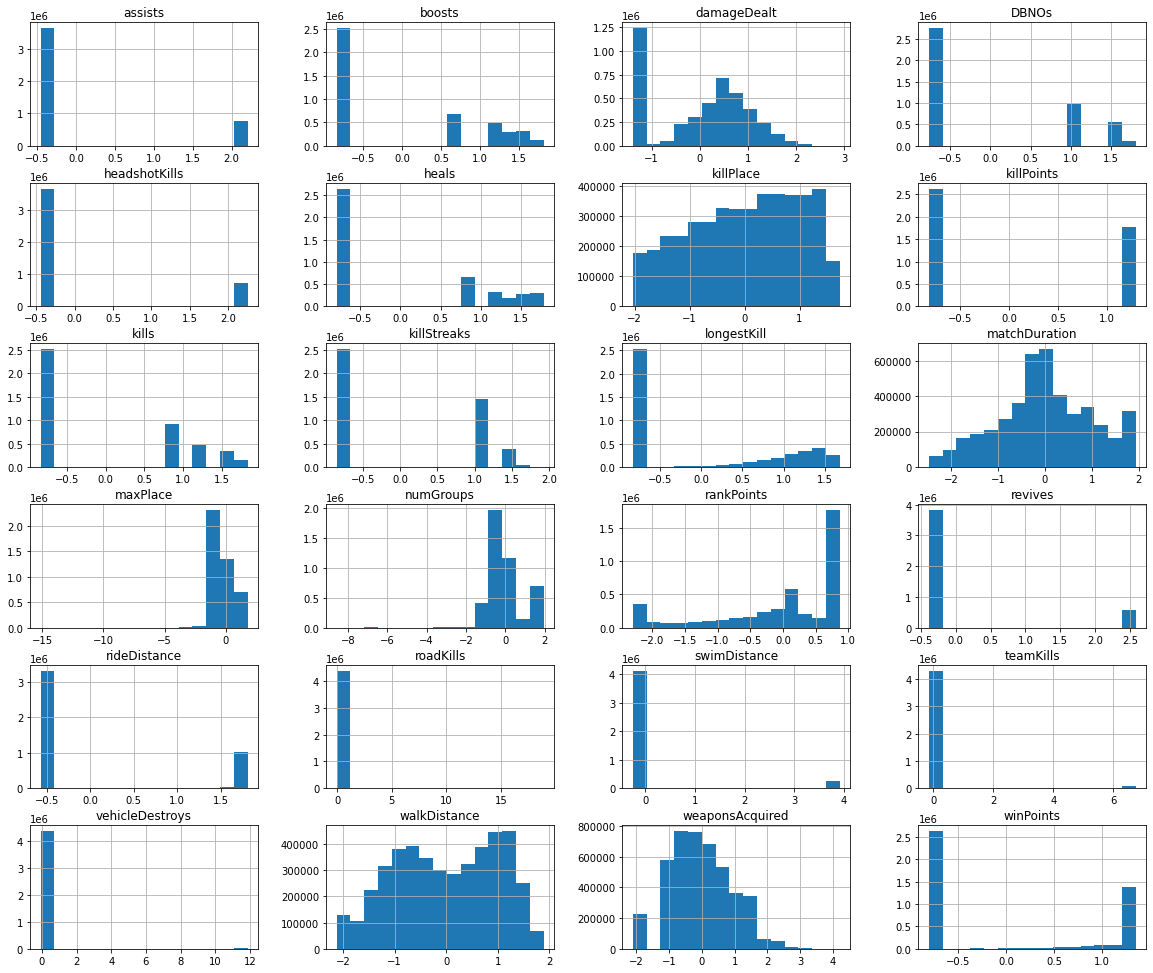

In [34]:
dfd_cle_viz_pow[dfd_num_cols].hist(bins=15, figsize=(20, 20), layout=(7, 4))
plt.title('Data Distributinos after power transformation')
plt.show()

In [35]:
dfd_cle_viz_pow

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,-0.456871,-0.841882,-1.394643,-0.765547,-0.445984,-0.793249,0.498044,...,-0.387314,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,-0.583442,-1.250467,1.299765,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,-0.456871,-0.841882,0.322451,-0.765547,-0.445984,-0.793249,0.399770,...,-0.387314,-0.564683,-0.052834,3.915593,-0.148225,-0.084225,0.621642,0.696822,-0.806439,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,2.183864,-0.841882,0.154137,-0.765547,-0.445984,-0.793249,0.061082,...,-0.387314,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,-0.791880,-0.626425,-0.806439,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,-0.456871,-0.841882,-0.212983,-0.765547,-0.445984,-0.793249,0.970470,...,-0.387314,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,-0.681345,-0.120097,-0.806439,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,-0.456871,-0.841882,0.375287,-0.765547,-0.445984,-0.793249,-0.008971,...,-0.387314,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,-1.271021,-0.626425,-0.806439,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398804,afff7f652dbc10,d238e426f50de7,18492834ce5635,-0.456871,-0.841882,-1.394643,-0.765547,-0.445984,-0.793249,0.939856,...,-0.387314,1.762852,-0.052834,-0.256397,-0.148225,-0.084225,0.342076,-0.120097,1.333491,0.1786
4398805,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,-0.456871,0.689257,-0.071654,-0.765547,-0.445984,-0.793249,0.785000,...,-0.387314,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,-1.088305,1.042764,-0.806439,0.2935
4398806,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,-0.456871,-0.841882,0.077987,-0.765547,-0.445984,-0.793249,0.690581,...,-0.387314,-0.570073,-0.052834,3.895325,-0.148225,-0.084225,0.148630,0.313528,-0.806439,0.4815
4398807,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,-0.456871,1.508075,0.752500,1.092457,2.238481,1.197856,-1.407921,...,2.584679,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,1.230150,1.653134,-0.806439,0.8000


#### 1.2.2.4 Standardization 

In [170]:
from sklearn.preprocessing import StandardScaler

dfd_cle_viz_std = dfd_cle_viz.copy()
std_sc = StandardScaler()
dfd_cle_viz_std[dfd_num_cols] = std_sc.fit_transform(dfd_cle_viz_std[dfd_num_cols])

In [ ]:
skew_df = pd.DataFrame(index=dfd_num_cols)

# Caculate Skewness 
skew_df['Skew'] = skew(dfd_cle_viz_std[dfd_num_cols], axis=0, bias=True) 
# Calculate the kurtosis
skew_df['Kurtosis'] = kurtosis(dfd_cle_viz_std[dfd_num_cols], axis=0, bias=True)

data_skew_dict['Skew']['std'] = skew_df['Skew'].apply(abs).mean()
data_skew_dict['Kurtosis']['std'] = skew_df['Kurtosis'].mean()
print('Skew Average: {:.2f} / Kurtosis Average: {:.2f}'.format(data_skew_dict['Skew']['std'], \
                                                       data_skew_dict['Kurtosis']['std']))


display(skew_df[ (np.absolute(skew_df['Skew'])>1) & (skew_df['Kurtosis']>1) ])

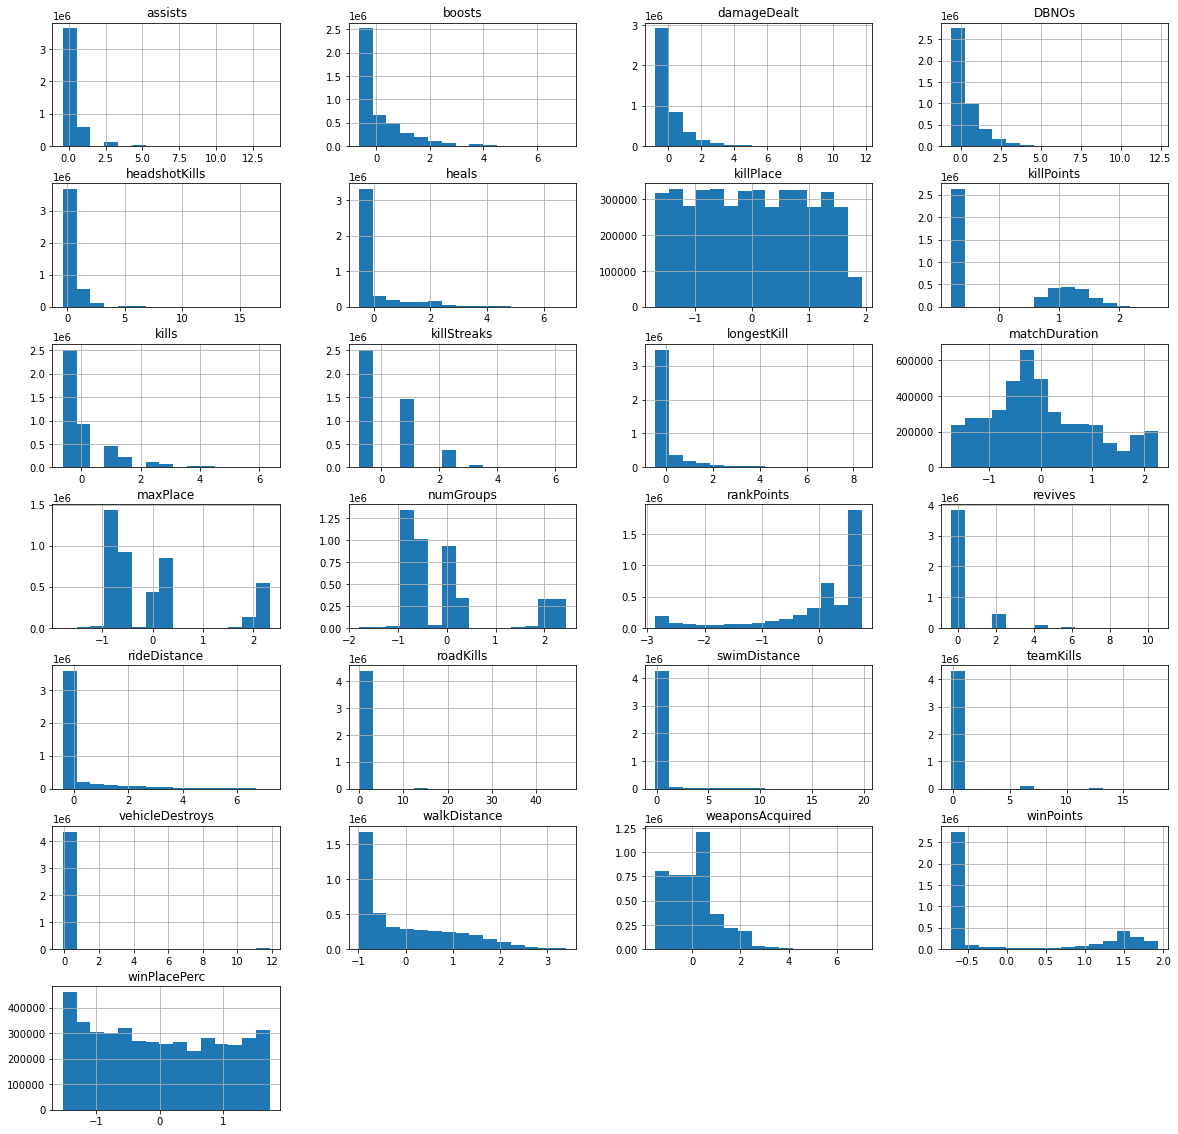

In [172]:
dfd_cle_viz_std[dfd_num_cols].hist(bins=15, figsize=(20, 20), layout=(7, 4))
plt.title('Data Distributinos after power transformation')
plt.show()

#### 1.2.2.5 Square Root Transformation

In [236]:
# we can transform every feature except for rankPoints, since that has negative, which log of return NaN
dfd_cle_viz_sqrt = dfd_cle_viz.copy()

cols = dfd_cle_viz_sqrt[dfd_num_cols].columns.tolist()
cols.remove('rankPoints')

for col in cols:
    dfd_cle_viz_sqrt[col] = np.sqrt(dfd_cle_viz_sqrt[col])

In [237]:
skew_df = pd.DataFrame(index=dfd_num_cols)

# Caculate Skewness 
skew_df['Skew'] = skew(dfd_cle_viz_sqrt[dfd_num_cols], axis=0, bias=True) 
# Calculate the kurtosis
skew_df['Kurtosis'] = kurtosis(dfd_cle_viz_sqrt[dfd_num_cols], axis=0, bias=True)

data_skew_dict['Skew']['sqrt'] = skew_df['Skew'].apply(abs).mean()
data_skew_dict['Kurtosis']['sqrt'] = skew_df['Kurtosis'].mean()
print('Skew Average: {:.2f} / Kurtosis Average: {:.2f}'.format(data_skew_dict['Skew']['sqrt'], \
                                                       data_skew_dict['Kurtosis']['sqrt']))

display(skew_df[ (np.absolute(skew_df['Skew'])>1) & (skew_df['Kurtosis']>1) ])

Skew Average: 2.63 / Kurtosis Average: 25.13


,Skew,Kurtosis
assists,2.045057,2.648671
headshotKills,2.120101,2.961602
longestKill,1.518384,1.872647
rankPoints,-1.593550,1.577988
revives,2.438073,4.344561
rideDistance,1.973764,2.626746
roadKills,19.688654,400.975555
swimDistance,5.647686,36.048946
teamKills,6.800787,45.495182
vehicleDestroys,11.788013,136.973007


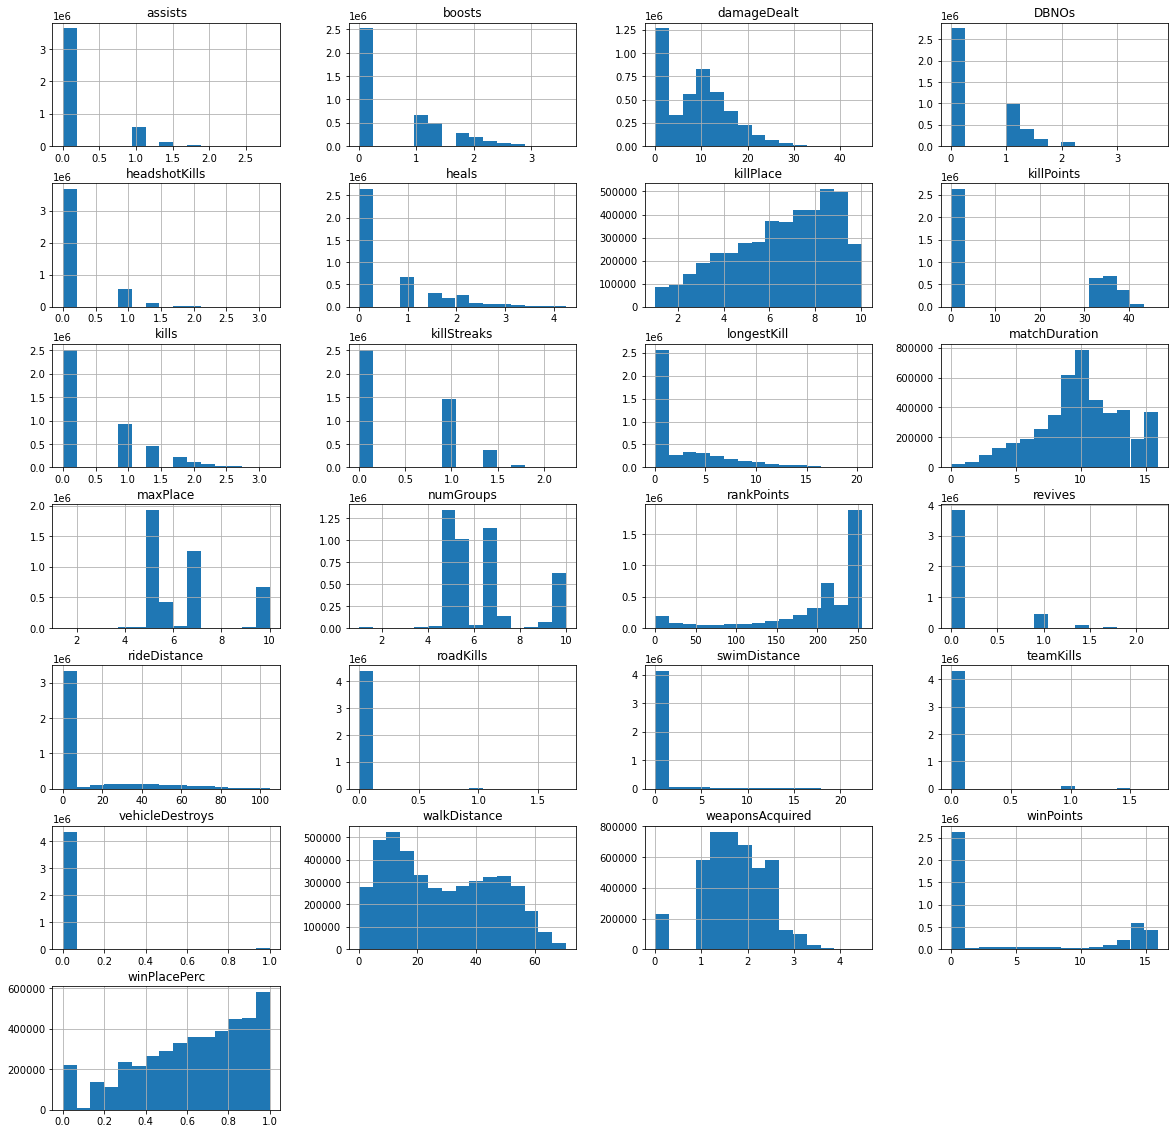

In [238]:
dfd_cle_viz_sqrt[dfd_num_cols].hist(bins=15, figsize=(20, 20), layout=(7, 4))
plt.title('Data Distributinos after power transformation')
plt.show()

#### 1.2.2.6 Cube Root Transformation

In [239]:
# we can transform every feature except for rankPoints, since that has negative, which log of return NaN
dfd_cle_viz_cbrt = dfd_cle_viz.copy()

cols = dfd_cle_viz_cbrt[dfd_num_cols].columns.tolist()
cols.remove('rankPoints')

for col in cols:
    dfd_cle_viz_cbrt[col] = np.cbrt(dfd_cle_viz_cbrt[col])

In [240]:
skew_df = pd.DataFrame(index=dfd_num_cols)

# Caculate Skewness 
skew_df['Skew'] = skew(dfd_cle_viz_cbrt[dfd_num_cols], axis=0, bias=True) 
# Calculate the kurtosis
skew_df['Kurtosis'] = kurtosis(dfd_cle_viz_cbrt[dfd_num_cols], axis=0, bias=True)

data_skew_dict['Skew']['cbrt'] = skew_df['Skew'].apply(abs).mean()
data_skew_dict['Kurtosis']['cbrt'] = skew_df['Kurtosis'].mean()
print('Skew Average: {:.2f} / Kurtosis Average: {:.2f}'.format(data_skew_dict['Skew']['cbrt'], \
                                                       data_skew_dict['Kurtosis']['cbrt']))

display(skew_df[ (np.absolute(skew_df['Skew'])>1) & (skew_df['Kurtosis']>1) ])

Skew Average: 2.52 / Kurtosis Average: 23.01


,Skew,Kurtosis
assists,1.888845,1.583952
headshotKills,1.960786,1.831796
rankPoints,-1.593550,1.577988
revives,2.298090,3.369794
rideDistance,1.641909,1.011832
roadKills,19.176250,370.858795
swimDistance,4.654790,22.273592
teamKills,6.673786,42.930004
vehicleDestroys,11.788013,136.973007
weaponsAcquired,-1.423164,3.001108


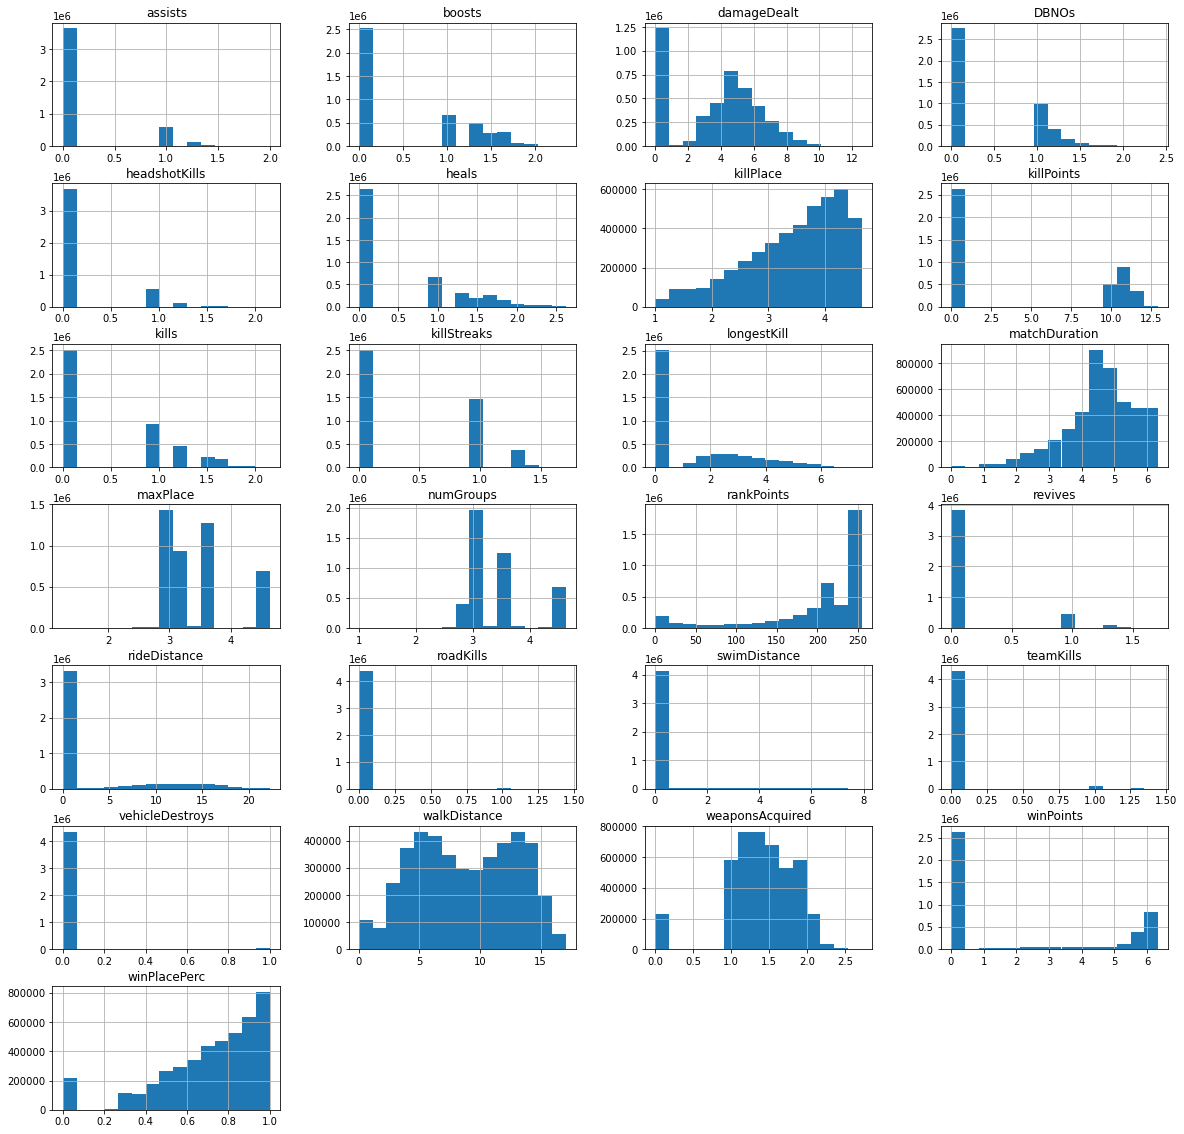

In [241]:
dfd_cle_viz_cbrt[dfd_num_cols].hist(bins=15, figsize=(20, 20), layout=(7, 4))
plt.title('Data Distributinos after power transformation')
plt.show()

#### 1.2.2.7 Box Cox  Transformation

In [243]:
from scipy.stats import boxcox

# we can transform every feature except for rankPoints, since that has negative, which log of return NaN
dfd_cle_viz_bcx = dfd_cle_viz.copy()

# to ensure data is positive (handling zeros in the data)
dfd_cle_viz_bcx.loc[:, dfd_num_cols] = dfd_cle_viz_bcx[dfd_num_cols].values + 1

cols = dfd_cle_viz_bcx[dfd_num_cols].columns.tolist()
cols.remove('rankPoints')

for col in cols:
    dfd_cle_viz_bcx[col] = boxcox(dfd_cle_viz_bcx[col])[0]

In [247]:
skew_df = pd.DataFrame(index=dfd_num_cols)

# Caculate Skewness 
skew_df['Skew'] = skew(dfd_cle_viz_bcx[dfd_num_cols], axis=0, bias=True) 
# Calculate the kurtosis
skew_df['Kurtosis'] = kurtosis(dfd_cle_viz_bcx[dfd_num_cols], axis=0, bias=True)

data_skew_dict['Skew']['bcx'] = skew_df['Skew'].apply(abs).mean()
data_skew_dict['Kurtosis']['bcx'] = skew_df['Kurtosis'].mean()
print('Skew Average: {:.2f} / Kurtosis Average: {:.2f}'.format(data_skew_dict['Skew']['bcx'], \
                                                       data_skew_dict['Kurtosis']['bcx']))

display(skew_df[ (np.absolute(skew_df['Skew'])>1) & (skew_df['Kurtosis']>1) ])

Skew Average: 2.17 / Kurtosis Average: 21.70


,Skew,Kurtosis
headshotKills,1.796272,1.226650
rankPoints,-1.591379,1.577987
revives,2.194572,2.816147
roadKills,18.874212,354.235866
swimDistance,3.648513,11.322169
teamKills,6.598275,41.537235
vehicleDestroys,11.788675,136.972852


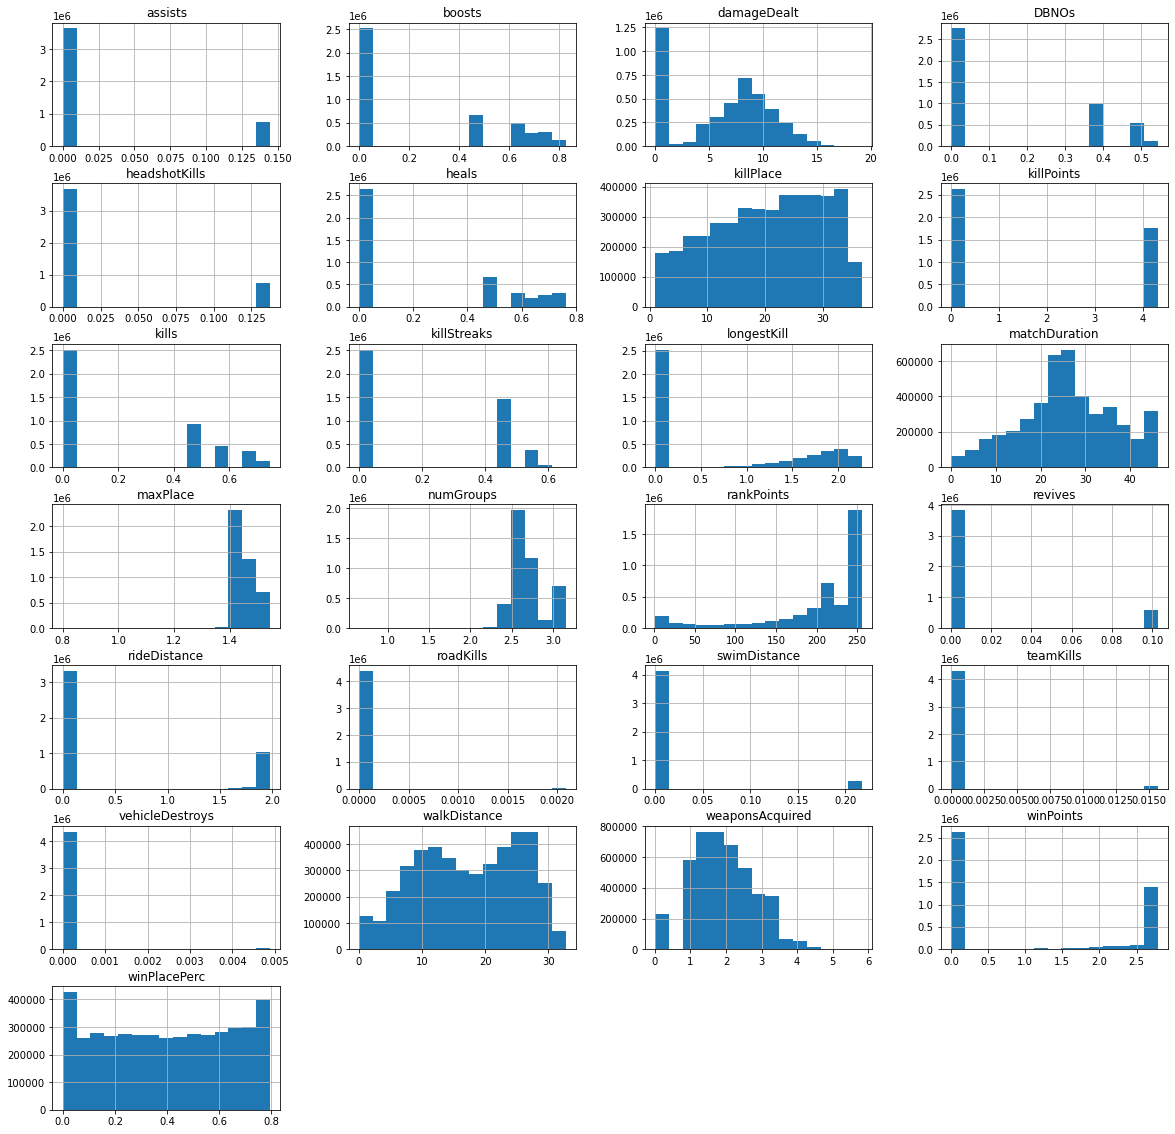

In [248]:
dfd_cle_viz_bcx[dfd_num_cols].hist(bins=15, figsize=(20, 20), layout=(7, 4))
plt.title('Data Distributinos after power transformation')
plt.show()

In [263]:
print(data_skew_dict, end='\n\n')

smallest_skew = min(data_skew_dict['Skew'].values())
smallest_kurtosis = min(data_skew_dict['Kurtosis'].values())
print('method with smallest skew score: {} ({} method)'.format(smallest_skew, \
                            list(data_skew_dict['Skew'].keys())[list(data_skew_dict['Skew'].values()).index(smallest_skew)]))
print('method with smallest kurtosis score: {}, ({} method)'.format(smallest_kurtosis, \
                 list(data_skew_dict['Kurtosis'].keys())[list(data_skew_dict['Kurtosis'].values()).index(smallest_kurtosis)]))

{'Skew': {'min-max': 8.366310504078864, 'log': 2.674602445960045, 'power': 2.1521727669984103, 'sqrt': 2.6327326595783234, 'cbrt': 2.515850819647312, 'bcx': 2.168778519170997}, 'Kurtosis': {'min-max': 444.6625671386719, 'log': 26.710588455200195, 'power': 21.637683868408203, 'sqrt': 25.126325607299805, 'cbrt': 23.00719451904297, 'bcx': 21.70275969278371}}

method with smallest skew score: 2.1521727669984103 (power method)
method with smallest kurtosis score: 21.637683868408203, (power method)


**INSIGHT** power transformation of data is had the best among the data transformation methods, in terms of having the least average kurtosis and skew scores. which means power transformation had the biggest effect on reducing skewness and imbalance within the data.

In [448]:
# the data used for the next cleaning process
dfd_cle_viz_pow

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,-0.456871,-0.841882,-1.394643,-0.765547,-0.445984,-0.793249,0.498044,...,-0.387314,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,-0.583442,-1.250467,1.299765,-0.015660
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,-0.456871,-0.841882,0.322451,-0.765547,-0.445984,-0.793249,0.399770,...,-0.387314,-0.564683,-0.052834,3.915593,-0.148225,-0.084225,0.621642,0.696822,-0.806439,0.600473
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,2.183864,-0.841882,0.154137,-0.765547,-0.445984,-0.793249,0.061082,...,-0.387314,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,-0.791880,-0.626425,-0.806439,1.001308
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,-0.456871,-0.841882,-0.212983,-0.765547,-0.445984,-0.793249,0.970470,...,-0.387314,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,-0.681345,-0.120097,-0.806439,-0.985473
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,-0.456871,-0.841882,0.375287,-0.765547,-0.445984,-0.793249,-0.008971,...,-0.387314,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,-1.271021,-0.626425,-0.806439,-0.908222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398804,afff7f652dbc10,d238e426f50de7,18492834ce5635,-0.456871,-0.841882,-1.394643,-0.765547,-0.445984,-0.793249,0.939856,...,-0.387314,1.762852,-0.052834,-0.256397,-0.148225,-0.084225,0.342076,-0.120097,1.333491,-0.941175
4398805,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,-0.456871,0.689257,-0.071654,-0.765547,-0.445984,-0.793249,0.785000,...,-0.387314,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,-1.088305,1.042764,-0.806439,-0.526873
4398806,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,-0.456871,-0.841882,0.077987,-0.765547,-0.445984,-0.793249,0.690581,...,-0.387314,-0.570073,-0.052834,3.895325,-0.148225,-0.084225,0.148630,0.313528,-0.806439,0.104961
4398807,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,-0.456871,1.508075,0.752500,1.092457,2.238481,1.197856,-1.407921,...,2.584679,-0.570073,-0.052834,-0.256397,-0.148225,-0.084225,1.230150,1.653134,-0.806439,1.071763


## 1.3 MutliCollinearity

### 1.3.1 Identifying features that possibly cause multicollinearity

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [37]:
# dfd_cle_viz_pow -> power-transformed data
X_variables = dfd_cle_viz_pow[dfd_num_cols]

vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

In [38]:
# get data for features with high VIF
vif_multicoll = vif_data[vif_data['VIF'] > 10]
features_multicoll = vif_multicoll['feature'].tolist()

# dropping dependent feature 
if 'winPlacePerc' in features_multicoll:
    features_multicoll.remove('winPlacePerc')

display(vif_multicoll)
print(f'feature that cause multicollinearity: {features_multicoll}')

,feature,VIF
6,killPlace,13.158685
7,killPoints,26.610341
8,kills,63.983380
9,killStreaks,37.712168
10,longestKill,16.670662
12,maxPlace,16.001398
13,numGroups,16.281280
23,winPoints,26.097349


feature that cause multicollinearity: ['killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'winPoints']


In [45]:
print('--> highest correlated pairs')

corr_mat = dfd_cle_viz_pow[features_multicoll].corr()
for x in range(len(list(dfd_cle_viz_pow[features_multicoll].columns))):
    corr_mat.iloc[0:x+1,x] = 0.0

pair_corr = pd.DataFrame()
pair_corr['col1'] = corr_mat.abs().idxmax()
pair_corr['col2'] = corr_mat.abs().idxmax().index
pair_corr['corr_score'] = corr_mat.abs().max()

corr_score_thresh = abs(pair_corr['corr_score']) > 0.70
display(pair_corr[ ((pair_corr['col1'].isin(features_multicoll)) | (pair_corr['col2'].isin(features_multicoll))) & corr_score_thresh])

--> highest correlated pairs


,col1,col2,corr_score
killPlace,kills,killPlace,0.895482
killPoints,winPoints,killPoints,0.980580
kills,killStreaks,kills,0.984168
killStreaks,longestKill,killStreaks,0.960543
maxPlace,numGroups,maxPlace,0.965019


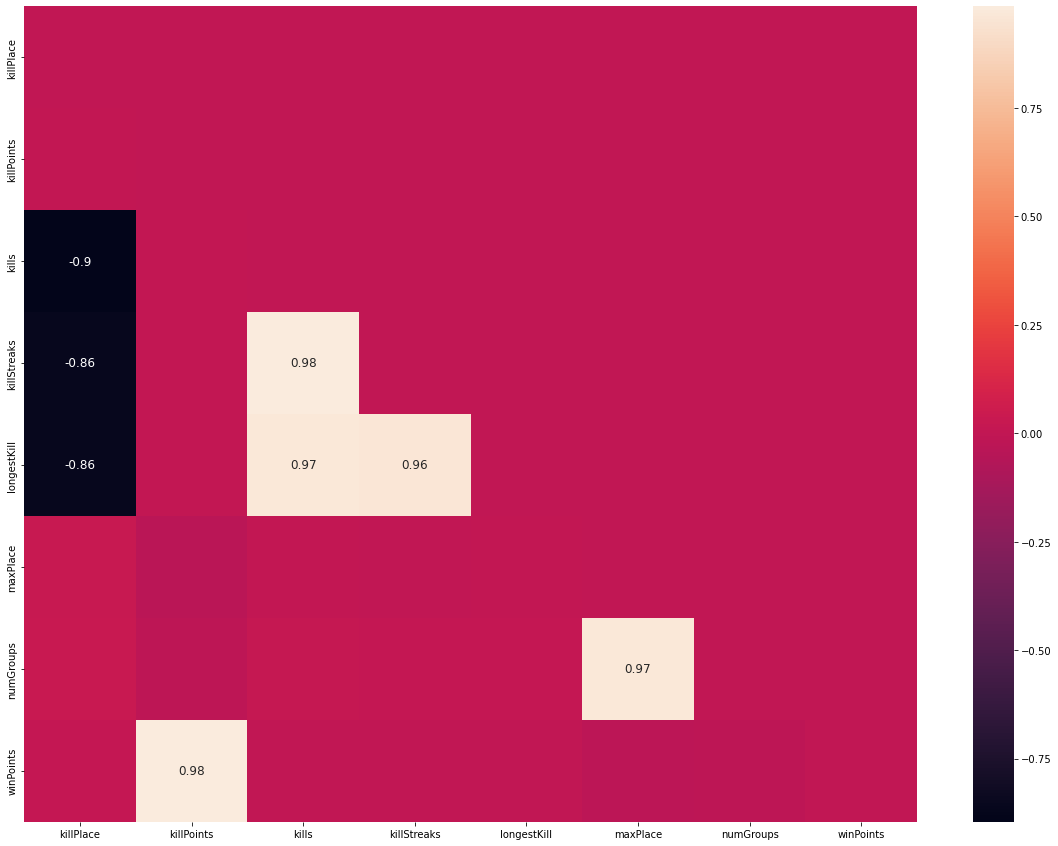

In [44]:
# Strip out the diagonal values for the next step
labels = corr_mat.applymap(lambda v: str(round(v, 2)) if abs(v) > 0.7 else '')  
    
plt.subplots(figsize=(20,15))
sns.heatmap(corr_mat, annot=labels, annot_kws={'fontsize':12}, fmt='')
plt.show()

**based on result above** 
- Apply PCA (for multicollinearity features highly correlated with other features)
    - **winPlacePerc** and **killPlace** + **killPlace** with (**kills**, **killStreaks**, **longestKill**) -> PC1
    - **winPoints** and **killPoints** -> PC2
    - **numGroups** and **maxPlace** -> PC3
- remove feauture (for multicollinearity features not highly correlated with any specific feature)
    - None

### 1.3.2 Handling MulitCollinearity

#### 1.3.2.1 Applying Dimensionality Reduction 

In [46]:
from sklearn.decomposition import PCA  

In [47]:
# dr: dimensionality reduction
dfd_cle_viz_pow_dr = dfd_cle_viz_pow.copy() # dr: dimensionality reduction

cols1 = ['killPlace', 'kills', 'killStreaks', 'longestKill']
# applying dimensionality reduction #1
pca = PCA(n_components=1)
pca.fit(dfd_cle_viz_pow_dr[cols1]) 
dfd_cle_viz_pow_dr_pt1 = pca.transform(dfd_cle_viz_pow_dr[cols1]) 
dfd_cle_viz_pow_dr_pt1 = pd.DataFrame(data = dfd_cle_viz_pow_dr_pt1, columns = ['PC1'])
dfd_cle_viz_pow_dr = dfd_cle_viz_pow_dr.drop(cols1, axis=1)
dfd_cle_viz_pow_dr['PC1'] = dfd_cle_viz_pow_dr_pt1

cols2 = ['winPoints', 'killPoints']
# applying dimensionality reduction #2
pca = PCA(n_components=1)
pca.fit(dfd_cle_viz_pow_dr[cols2]) 
dfd_cle_viz_pow_dr_pt2 = pca.transform(dfd_cle_viz_pow_dr[cols2]) 
dfd_cle_viz_pow_dr_pt2 = pd.DataFrame(data = dfd_cle_viz_pow_dr_pt2, columns = ['PC2'])
dfd_cle_viz_pow_dr = dfd_cle_viz_pow_dr.drop(cols2, axis=1)
dfd_cle_viz_pow_dr['PC2'] = dfd_cle_viz_pow_dr_pt2

cols3 = ['numGroups', 'maxPlace']
# applying dimensionality reduction #3
pca = PCA(n_components=1)
pca.fit(dfd_cle_viz_pow_dr[cols3]) 
dfd_cle_viz_pow_dr_pt3 = pca.transform(dfd_cle_viz_pow_dr[cols3]) 
dfd_cle_viz_pow_dr_pt3 = pd.DataFrame(data = dfd_cle_viz_pow_dr_pt3, columns = ['PC3'])
dfd_cle_viz_pow_dr = dfd_cle_viz_pow_dr.drop(cols3, axis=1)
dfd_cle_viz_pow_dr['PC3'] = dfd_cle_viz_pow_dr_pt3

#### 1.3.2.2 Removing the MultiCollinearity-Causing Feature

None to remove

In [46]:
# dfd_cle_viz_pow_dr = dfd_cle_viz_pow_dr.drop(['rankPoints'], axis=1)
# dfd_cle_viz_pow_dr

### 1.3.3 checking for remaining correlations

In [48]:
# redefining the numerical features of the data
dfd_num_cols_dr = dfd_cle_viz_pow_dr.dtypes[dfd_cle_viz_pow_dr.dtypes != 'object'].index.tolist()
dfd_num_cols_dr

['assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'matchDuration',
 'rankPoints',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired',
 'winPlacePerc',
 'PC1',
 'PC2',
 'PC3']

In [49]:
X_variables = dfd_cle_viz_pow_dr[dfd_num_cols_dr]

vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

# get data for features with high VIF
vif_multicoll = vif_data[vif_data['VIF'] > 10]
features_multicoll = vif_multicoll['feature'].tolist()

,feature,VIF


features that cause multicollinearity: []


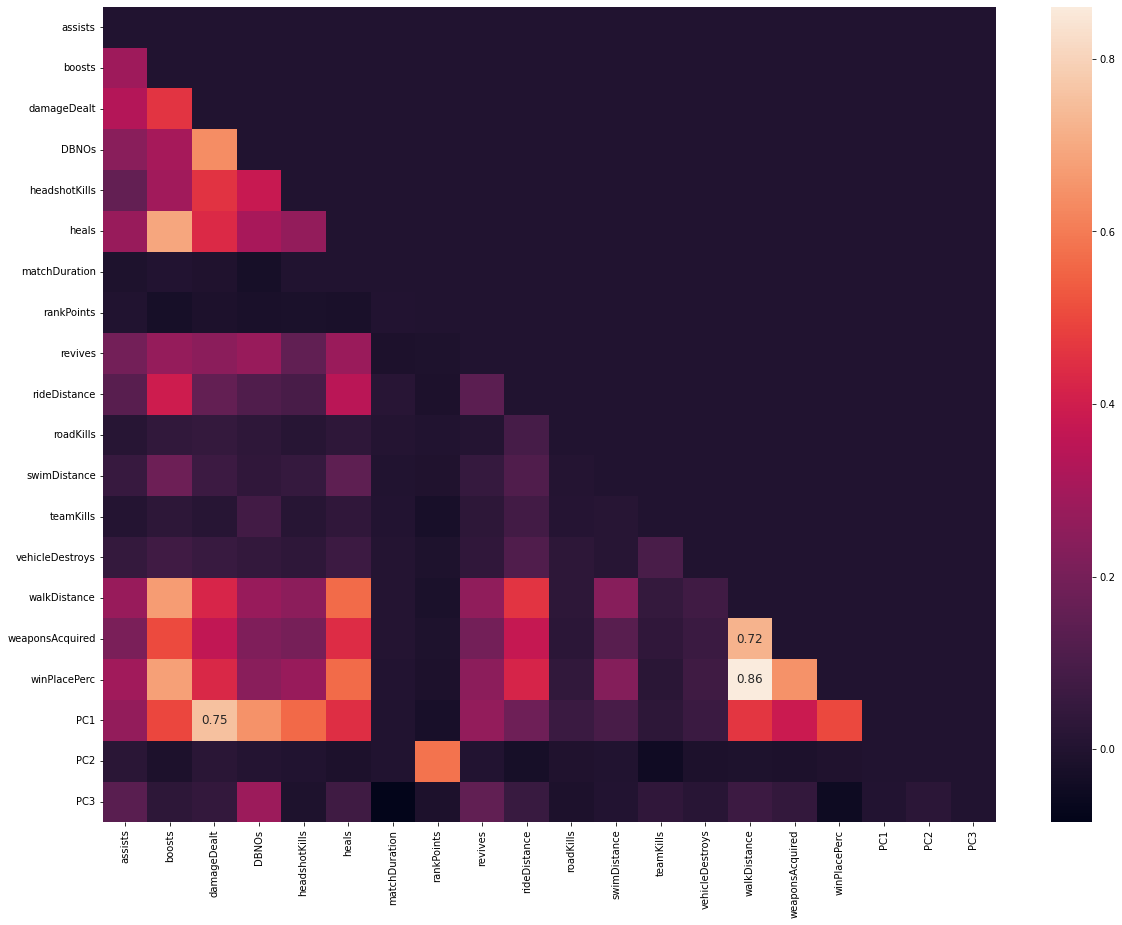

In [50]:
# dropping dependent feature 
if 'winPlacePerc' in features_multicoll:
    features_multicoll.remove('winPlacePerc')

# vif results
display(vif_multicoll[vif_multicoll['feature'].isin(features_multicoll)])
print(f'features that cause multicollinearity: {features_multicoll}')

# correlation matrix
corr_mat = dfd_cle_viz_pow_dr[dfd_num_cols_dr].corr()

# Strip out the diagonal values for the next step
for x in range(len(list(dfd_cle_viz_pow_dr[dfd_num_cols_dr].columns))):
    corr_mat.iloc[0:x+1,x] = 0.0

labels = corr_mat.applymap(lambda v: str(round(v, 2)) if abs(v) > 0.7 else '')  
    
plt.subplots(figsize=(20,15))
sns.heatmap(corr_mat, annot=labels, annot_kws={'fontsize':12}, fmt='')
plt.show()

**NOTE** there is a correlation, but no high VIF scores indicate there is aren't any signficant multicollinearity present within the data.

## 1.4 Dropping non-relevant features

the ID features (Id, groupId, matchId) are going to provide useful information for inferring predictions about the winPlacePerc for the data. in fact, encoding these features would waste computation, in addition to the possibility of the model misinterpreting those ID features as some numerical (ecnoded) value that has relation to predicting the value.

due to these reasons, we're omitting the ID features from the data.

In [51]:
dfd_cle_viz_pow_dr = dfd_cle_viz_pow_dr.drop(['Id', 'groupId', 'matchId'], axis=1)

In [52]:
dfd_cle_viz_pow_dr

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,matchDuration,matchType,rankPoints,revives,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,PC1,PC2,PC3
0,-0.456871,-0.841882,-1.394643,-0.765547,-0.445984,-0.793249,-1.465949,squad-fpp,0.868970,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,-0.583442,-1.250467,0.4444,-1.521681,1.780035,1.118023
1,-0.456871,-0.841882,0.322451,-0.765547,-0.445984,-0.793249,1.781797,squad-fpp,-0.143440,-0.387314,...,-0.052834,3.915593,-0.148225,-0.084225,0.621642,0.696822,0.6400,-1.474546,-1.151203,1.332309
2,2.183864,-0.841882,0.154137,-0.765547,-0.445984,-0.793249,-1.174668,duo,-0.014304,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,-0.791880,-0.626425,0.7755,-1.312102,-1.151203,-0.780248
3,-0.456871,-0.841882,-0.212983,-0.765547,-0.445984,-0.793249,0.761739,squad-fpp,-1.332528,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,-0.681345,-0.120097,0.1667,-1.748270,-1.151203,0.693416
4,-0.456871,-0.841882,0.375287,-0.765547,-0.445984,-0.793249,0.601761,solo-fpp,-2.240680,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,-1.271021,-0.626425,0.1875,1.635239,-1.151203,-2.550022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398804,-0.456871,-0.841882,-1.394643,-0.765547,-0.445984,-0.793249,-0.344273,squad-fpp,0.868970,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,0.342076,-0.120097,0.1786,-1.733586,1.783891,0.930601
4398805,-0.456871,0.689257,-0.071654,-0.765547,-0.445984,-0.793249,0.748596,solo,0.175670,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,-1.088305,1.042764,0.2935,-1.659313,-1.151203,-2.480395
4398806,-0.456871,-0.841882,0.077987,-0.765547,-0.445984,-0.793249,-1.107664,squad-fpp,0.156384,-0.387314,...,-0.052834,3.895325,-0.148225,-0.084225,0.148630,0.313528,0.4815,-1.614027,-1.151203,1.000170
4398807,-0.456871,1.508075,0.752500,1.092457,2.238481,1.197856,-0.146514,squad-fpp,-1.199215,2.584679,...,-0.052834,-0.256397,-0.148225,-0.084225,1.230150,1.653134,0.8000,2.595580,-1.151203,1.332309


# 2- Data Preprocessing and Preparation

## 2.1 Encoding categorical Variables

In [53]:
from sklearn.preprocessing import OrdinalEncoder

In [54]:
oe = OrdinalEncoder()
selected_corr_df = dfd_cle_viz_pow_dr[['matchType']]  # (X_corr, y_corr)
dfd_cle_viz_pow_dr_enc = dfd_cle_viz_pow_dr.copy()

oe.fit(selected_corr_df)
selected_corr_df = pd.DataFrame(oe.transform(selected_corr_df), columns=['matchType'])  # ordinal encoder
dfd_cle_viz_pow_dr_enc['matchType'] = selected_corr_df['matchType'].astype('int16')
dfd_cle_viz_pow_dr_enc['matchType'].value_counts()

15    1738479
3      988111
14     619245
13     531934
2      310556
12     179828
11      14334
0        6137
7        4991
5        2439
9         973
4         705
10        380
1         360
8         184
6         153
Name: matchType, dtype: int64

In [55]:
dfd_cle_viz_pow_dr_enc

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,matchDuration,matchType,rankPoints,revives,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,PC1,PC2,PC3
0,-0.456871,-0.841882,-1.394643,-0.765547,-0.445984,-0.793249,-1.465949,15,0.868970,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,-0.583442,-1.250467,0.4444,-1.521681,1.780035,1.118023
1,-0.456871,-0.841882,0.322451,-0.765547,-0.445984,-0.793249,1.781797,15,-0.143440,-0.387314,...,-0.052834,3.915593,-0.148225,-0.084225,0.621642,0.696822,0.6400,-1.474546,-1.151203,1.332309
2,2.183864,-0.841882,0.154137,-0.765547,-0.445984,-0.793249,-1.174668,2,-0.014304,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,-0.791880,-0.626425,0.7755,-1.312102,-1.151203,-0.780248
3,-0.456871,-0.841882,-0.212983,-0.765547,-0.445984,-0.793249,0.761739,15,-1.332528,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,-0.681345,-0.120097,0.1667,-1.748270,-1.151203,0.693416
4,-0.456871,-0.841882,0.375287,-0.765547,-0.445984,-0.793249,0.601761,13,-2.240680,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,-1.271021,-0.626425,0.1875,1.635239,-1.151203,-2.550022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398804,-0.456871,-0.841882,-1.394643,-0.765547,-0.445984,-0.793249,-0.344273,15,0.868970,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,0.342076,-0.120097,0.1786,-1.733586,1.783891,0.930601
4398805,-0.456871,0.689257,-0.071654,-0.765547,-0.445984,-0.793249,0.748596,12,0.175670,-0.387314,...,-0.052834,-0.256397,-0.148225,-0.084225,-1.088305,1.042764,0.2935,-1.659313,-1.151203,-2.480395
4398806,-0.456871,-0.841882,0.077987,-0.765547,-0.445984,-0.793249,-1.107664,15,0.156384,-0.387314,...,-0.052834,3.895325,-0.148225,-0.084225,0.148630,0.313528,0.4815,-1.614027,-1.151203,1.000170
4398807,-0.456871,1.508075,0.752500,1.092457,2.238481,1.197856,-0.146514,15,-1.199215,2.584679,...,-0.052834,-0.256397,-0.148225,-0.084225,1.230150,1.653134,0.8000,2.595580,-1.151203,1.332309


## 2.2 Feature Engineering

In [56]:
dfd_cle_viz_pow_dr_enc.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'matchDuration', 'matchType', 'rankPoints', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired', 'winPlacePerc', 'PC1', 'PC2', 'PC3'],
      dtype='object')

In [57]:
dfd_cle_viz_pow_dr_enc_feng = dfd_cle_viz_pow_dr_enc.copy()
dfd_cle_viz_pow_dr_enc_feng['_totalDistance'] = 0.25 * dfd_cle_viz_pow_dr_enc_feng['rideDistance'] + dfd_cle_viz_pow_dr_enc_feng["walkDistance"] + dfd_cle_viz_pow_dr_enc_feng["swimDistance"]
dfd_cle_viz_pow_dr_enc_feng['_totalDistance_weaponsAcq_Ratio'] = dfd_cle_viz_pow_dr_enc_feng['_totalDistance'] / dfd_cle_viz_pow_dr_enc_feng['weaponsAcquired']
dfd_cle_viz_pow_dr_enc_feng['_walkDistance_heals_Ratio'] = dfd_cle_viz_pow_dr_enc_feng['walkDistance'] / (dfd_cle_viz_pow_dr_enc_feng['heals'] + 1)
dfd_cle_viz_pow_dr_enc_feng['_totalDistancePerDuration'] =  dfd_cle_viz_pow_dr_enc_feng["_totalDistance"] / dfd_cle_viz_pow_dr_enc_feng["matchDuration"]
dfd_cle_viz_pow_dr_enc_feng['_walkDistancePerDuration'] =  dfd_cle_viz_pow_dr_enc_feng["walkDistance"]/dfd_cle_viz_pow_dr_enc_feng["matchDuration"]

In [58]:
# handling missing values (fill missing with mean as to not affect the overall distribution for each feature)
new_features_df = dfd_cle_viz_pow_dr_enc_feng.iloc[:, -5:]
display(new_features_df.isnull().sum())
for col in new_features_df.columns:
    new_features_df[col] = new_features_df[col].fillna((new_features_df[col].mean()))

display(new_features_df.isnull().sum())

_totalDistance                     0
_totalDistance_weaponsAcq_Ratio    0
_walkDistance_heals_Ratio          0
_totalDistancePerDuration          0
_walkDistancePerDuration           0
dtype: int64

_totalDistance                     0
_totalDistance_weaponsAcq_Ratio    0
_walkDistance_heals_Ratio          0
_totalDistancePerDuration          0
_walkDistancePerDuration           0
dtype: int64

In [59]:
# replacing infinity values with 0
new_features_df = new_features_df.replace([np.inf, -np.inf], 0)

In [60]:
# data transformation
pw = PowerTransformer()
cols = new_features_df.columns
new_features_df = pw.fit_transform(new_features_df)
skew_df = pd.DataFrame(index=cols)

skew_df['Skew'] = skew(new_features_df, axis=0, bias=True) 
skew_df['Kurtosis'] = kurtosis(new_features_df, axis=0, bias=True)
print('Skew Average: {:.2f} / Kurtosis Average: {:.2f}'.format(skew_df['Skew'].apply(abs).mean(), \
                                                       skew_df['Kurtosis'].mean()))
display(skew_df[ (np.absolute(skew_df['Skew'])>1) & (skew_df['Kurtosis']>1) ])

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Skew Average: 0.77 / Kurtosis Average: 78.04


,Skew,Kurtosis
_totalDistancePerDuration,-2.743522,255.928558


**INSIGHT** after applying transformation there is no skewness within the new features

In [61]:
dfd_cle_viz_pow_dr_enc_feng.iloc[:, -5:] = new_features_df
dfd_cle_viz_pow_dr_enc_feng

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,matchDuration,matchType,rankPoints,revives,...,weaponsAcquired,winPlacePerc,PC1,PC2,PC3,_totalDistance,_totalDistance_weaponsAcq_Ratio,_walkDistance_heals_Ratio,_totalDistancePerDuration,_walkDistancePerDuration
0,-0.456871,-0.841882,-1.394643,-0.765547,-0.445984,-0.793249,-1.465949,15,0.868970,-0.387314,...,-1.250467,0.4444,-1.521681,1.780035,1.118023,-0.541769,-0.173399,-0.508388,0.000732,0.022427
1,-0.456871,-0.841882,0.322451,-0.765547,-0.445984,-0.793249,1.781797,15,-0.143440,-0.387314,...,0.696822,0.6400,-1.474546,-1.151203,1.332309,2.006998,1.187558,1.232389,0.049966,0.020291
2,2.183864,-0.841882,0.154137,-0.765547,-0.445984,-0.793249,-1.174668,2,-0.014304,-0.387314,...,-0.626425,0.7755,-1.312102,-1.151203,-0.780248,-0.739599,0.070614,-0.753076,0.010070,0.034431
3,-0.456871,-0.841882,-0.212983,-0.765547,-0.445984,-0.793249,0.761739,15,-1.332528,-0.387314,...,-0.120097,0.1667,-1.748270,-1.151203,0.693416,-0.633478,1.944721,-0.624267,-0.054778,-0.033966
4,-0.456871,-0.841882,0.375287,-0.765547,-0.445984,-0.793249,0.601761,13,-2.240680,-0.387314,...,-0.626425,0.1875,1.635239,-1.151203,-2.550022,-1.229652,0.249433,-1.292076,-0.090049,-0.087327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398804,-0.456871,-0.841882,-1.394643,-0.765547,-0.445984,-0.793249,-0.344273,15,0.868970,-0.387314,...,-0.120097,0.1786,-1.733586,1.783891,0.930601,0.556747,-0.994033,0.765053,-0.057675,-0.038305
4398805,-0.456871,0.689257,-0.071654,-0.765547,-0.445984,-0.793249,0.748596,12,0.175670,-0.387314,...,1.042764,0.2935,-1.659313,-1.151203,-2.480395,-1.037182,-0.569287,-1.089769,-0.069605,-0.058457
4398806,-0.456871,-0.841882,0.077987,-0.765547,-0.445984,-0.793249,-1.107664,15,0.156384,-0.387314,...,0.313528,0.4815,-1.614027,-1.151203,1.000170,1.861010,2.975631,0.459297,-0.109321,-0.000751
4398807,-0.456871,1.508075,0.752500,1.092457,2.238481,1.197856,-0.146514,15,-1.199215,2.584679,...,1.653134,0.8000,2.595580,-1.151203,1.332309,0.713042,-0.231242,0.409192,-0.164391,-0.364153


## 2.3 Splitting Data

In [430]:
from sklearn.model_selection import train_test_split

**NOTE** we picked dfd_cle_viz because it has the same number of records as dfd_cle_viz_pow_dr_enc_feng, as well as having the non-transformed dependant feature winPlacePerc, so, we'll use for extracting the dependant feature values for winPlacePerc.

In [442]:
# we picked dfd_cle_viz because it has the same number of records as dfd_cle_viz_pow_dr_enc_feng, 
#as well it has the non-transformed dependant feature winPlacePerc, so, we'll use for extracting the dependant feature values 
# for winPlacePerc
X = dfd_cle_viz_pow_dr_enc_feng.copy()
y = dfd_cle_viz['winPlacePerc']  

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 3- Saving Datasets to files

In [62]:
# RR: rows removed
dfd_cle_pt1.to_csv('../Data/processed/dfd_cle_RR.csv', index=False)

In [63]:
# viz: outlier removal by visualization method 
dfd_cle_viz.to_csv('../Data/processed/dfd_cle_RR_viz.csv', index=False)

In [64]:
# pow: power data tranformation applied
dfd_cle_viz_pow.to_csv('../Data/processed/dfd_cle_RR_viz_pow.csv', index=False)

In [65]:
# dr: dimensionality reduction applied (to handle multi-collinearity)
dfd_cle_viz_pow_dr['winPlacePerc'] = dfd_cle_viz['winPlacePerc']  
display(dfd_cle_viz_pow_dr.isnull().sum())
dfd_cle_viz_pow_dr.to_csv('../Data/processed/dfd_cle_RR_viz_pow_dr.csv', index=False)

assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
matchDuration      0
matchType          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPlacePerc       0
PC1                0
PC2                0
PC3                0
dtype: int64

In [66]:
# enc: categorical data encoded
dfd_cle_viz_pow_dr_enc['winPlacePerc'] = dfd_cle_viz['winPlacePerc']
display(dfd_cle_viz_pow_dr_enc.isnull().sum())
dfd_cle_viz_pow_dr_enc.to_csv('../Data/processed/dfd_cle_RR_viz_pow_dr_enc.csv', index=False)

assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
matchDuration      0
matchType          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPlacePerc       0
PC1                0
PC2                0
PC3                0
dtype: int64

In [67]:
# feng: engineered features added
dfd_cle_viz_pow_dr_enc_feng['winPlacePerc'] = dfd_cle_viz['winPlacePerc'] 
display(dfd_cle_viz_pow_dr_enc_feng.isnull().sum())
dfd_cle_viz_pow_dr_enc_feng.to_csv('../Data/processed/dfd_cle_RR_viz_pow_dr_enc_feng.csv', index=False)

assists                            0
boosts                             0
damageDealt                        0
DBNOs                              0
headshotKills                      0
heals                              0
matchDuration                      0
matchType                          0
rankPoints                         0
revives                            0
rideDistance                       0
roadKills                          0
swimDistance                       0
teamKills                          0
vehicleDestroys                    0
walkDistance                       0
weaponsAcquired                    0
winPlacePerc                       0
PC1                                0
PC2                                0
PC3                                0
_totalDistance                     0
_totalDistance_weaponsAcq_Ratio    0
_walkDistance_heals_Ratio          0
_totalDistancePerDuration          0
_walkDistancePerDuration           0
dtype: int64

# References

- https://towardsdatascience.com/how-to-handle-large-datasets-in-python-with-pandas-and-dask-34f43a897d55
- https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
- https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft
- https://tutorial.dask.org/01_dataframe.html
- https://stackabuse.com/ultimate-guide-to-heatmaps-in-seaborn-with-python/


- https://www.marsja.se/transform-skewed-data-using-square-root-log-box-cox-methods-in-python/
- https://www.statology.org/transform-data-in-python/
- https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725